### VIT From Scratch

###### Downloading Packages

In [ ]:
!pip install -qU einops==0.7.0 torch torchvision datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 665.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torch import nn, optim
from tqdm import tqdm

###### Attention & MLP

In [ ]:
# Helper function to ensure that dimensions are given as tuples (useful for image dimensions)
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# Defining the Attention mechanism class
class Attention(nn.Module):
    def __init__(self, dim, heads=16, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads  # Total dimension of all heads combined
        project_out = not (heads == 1 and dim_head == dim)  # Condition to decide whether to project output

        self.heads = heads  # Number of attention heads
        self.scale = dim_head ** -0.5  # Scaling factor for dot products

        self.norm = nn.LayerNorm(dim)  # Layer normalization

        self.attend = nn.Softmax(dim=-1)  # Softmax to calculate attention weights
        self.dropout = nn.Dropout(dropout)  # Dropout layer

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)  # Linear transformation to get queries, keys, values

        # Output projection, only applied if needed (depends on the dimensions)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),  # Linear layer to project back to the original dimension
            nn.Dropout(dropout)  # Dropout layer
        ) if project_out else nn.Identity()  # Pass through if no projection needed

    def forward(self, x):
        x = self.norm(x)  # Normalize input

        # Split the input into queries, keys, values
        qkv = self.to_qkv(x).chunk(3, dim=-1)  # Split into three equal parts
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)  # Rearrange for multi-head attention

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale  # Dot product of queries and keys, scaled
        attn = self.attend(dots)  # Apply softmax to get attention weights
        attn = self.dropout(attn)  # Apply dropout to attention weights

        out = torch.matmul(attn, v)  # Weighted sum of values
        out = rearrange(out, 'b h n d -> b n (h d)')  # Rearrange back to the original format
        return self.to_out(out)  # Project output if required and return


# Defining the FeedForward network module within the transformer block
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        # Sequential layer containing normalization, linear, activation, and dropout layers
        self.net = nn.Sequential(
            nn.LayerNorm(dim),  # Normalizes the input data (mean=0, std=1)
            nn.Linear(dim, hidden_dim),  # Linear transformation to a higher dimensional space
            nn.GELU(),  # Gaussian Error Linear Unit (GELU) non-linear activation
            nn.Dropout(dropout),  # Dropout for regularization, reducing overfitting
            nn.Linear(hidden_dim, dim),  # Linear transformation back to original dimension
            nn.Dropout(dropout)  # Another dropout layer for regularization
        )

    def forward(self, x):
        return self.net(x)  # Passes the input through the sequential network

###### Transformer & Overall VIT

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super().__init__()
        self.norm = nn.LayerNorm(dim)  # Layer normalization applied to the output of the last layer
        self.layers = nn.ModuleList([])  # Container for all the transformer blocks
        for _ in range(depth):  # Loop to create multiple layers of the transformer
            # Each layer contains an attention block and a feedforward network
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout),  # Multi-head attention layer
                FeedForward(dim, mlp_dim, dropout=dropout)  # Feedforward layer following the attention
            ]))

    def forward(self, x):
        for attn, ff in self.layers:  # Iterate through each pair of attention and feedforward layers
            x = attn(x) + x  # Apply attention, add the result to the input (residual connection)
            x = ff(x) + x  # Apply feedforward network, add the result to the input (residual connection)
        return self.norm(x)  # Apply normalization to the final output of the layers

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)  # Ensure image dimensions are in tuple format
        patch_height, patch_width = pair(patch_size)  # Ensure patch dimensions are in tuple format
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # Calculate total number of patches
        patch_dim = channels * patch_height * patch_width  # Calculate dimensionality of each patch
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        # Sequential model for patch embedding and dimensionality adjustment
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),  # Rearrange image into patches
            nn.LayerNorm(patch_dim),  # Normalize patches
            nn.Linear(patch_dim, dim),  # Linear layer to project patch dimensions into model dimension
            nn.LayerNorm(dim),  # Normalize again after linear transformation
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))  # Positional embeddings for patches + cls token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))  # Learnable class token added to the sequence
        self.dropout = nn.Dropout(emb_dropout)  # Dropout applied to embeddings

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)  # The transformer model

        self.pool = pool  # Pooling type ('cls' for class token, 'mean' for mean pooling)
        self.to_latent = nn.Identity()  # Identity layer, can be replaced with additional processing layers
        self.mlp_head = nn.Linear(dim, num_classes)  # Final linear layer to output logits for each class

    def forward(self, img):
        x = self.to_patch_embedding(img)  # Embed patches of the input image
        b, n, _ = x.shape  # Get batch size and number of patches
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)  # Repeat cls token across the batch
        x = torch.cat((cls_tokens, x), dim=1)  # Concatenate cls tokens with patch embeddings

        x += self.pos_embedding[:, :(n + 1)]  # Add positional embeddings to the sequence
        x = self.dropout(x)  # Apply dropout to the combined embeddings

        x = self.transformer(x)  # Pass through the transformer

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]  # Pool the transformer outputs to a single vector

        x = self.to_latent(x)  # Pass through the identity layer (can be customized)
        return self.mlp_head(x)  # Output logits for each class

###### Loading The Model

In [ ]:
# Initialize the Vision Transformer model with specified parameters
d_model = 768  # Dimension of the model embeddings
model = ViT(
    image_size = 32,  # Size of the input images
    patch_size = 8,   # Size of the patches to break down images into
    num_classes = 10,  # Number of output classes (CIFAR-10 has 10 classes)
    dim = d_model,    # Dimensionality of the model
    depth = 12,        # Number of transformer blocks
    heads = 12,       # Number of attention heads
    mlp_dim = 4*d_model,  # Dimensionality of the feedforward network inside transformers
    dropout = 0.1,    # Dropout rate for regularization
    emb_dropout = 0.2 # Dropout rate for the embedding layer
)
# Set training parameters
epochs = 20  # Number of training epochs
seed = 42   # Seed for random number generation

# Set batch size for data loading
batch_size = 32

In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters in the model
num_trainable_params = count_trainable_parameters(model)
formatted_params = f"{num_trainable_params:,}"  # Format with commas
print(f"Number of trainable parameters: {formatted_params}")

In [ ]:
def print_dataset_lengths(train_dataset, test_dataset):
    """Prints the lengths of the training and testing datasets."""
    print(f"Length of train dataset: {len(train_dataset)}")
    print(f"Length of test dataset: {len(test_dataset)}")

###### Display Images Function

In [ ]:
def show_images_grid(dataset, num_images=25, cols=5):
    """
    Display a grid of images and their labels from a dataset.

    Args:
    dataset (Dataset): The dataset from which images and labels are taken.
    num_images (int): Number of images to display. Default is 25.
    cols (int): Number of columns in the image grid. Default is 5.
    """
    # Calculate number of rows needed
    rows = num_images // cols + int(num_images % cols != 0)

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 1.5, rows * 1.5))
    axes = axes.flatten()

    # Get random indices of images to display
    indices = torch.randperm(len(dataset))[:num_images]

    for ax, idx in zip(axes, indices):
        # Load the image and label
        image, label = dataset[idx]

        # Convert tensor image to numpy for plotting
        if image.shape[0] == 1:  # Single channel image
            image = image.squeeze(0)  # Remove channel dimension for grayscale images
        elif image.shape[0] == 3:  # RGB image
            image = image.permute(1, 2, 0)  # Convert to H, W, C format

        image = image.numpy()

        # Normalize image for display if it's not in the range [0, 1]
        if image.min() < 0:
            image = (image + 1) / 2  # Assuming normalization was mean=0.5, std=0.5

        # Display the image
        ax.imshow(image, cmap='gray' if image.ndim == 2 else None)
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    # Adjust subplot params so that subplots fit into the figure area.
    plt.tight_layout()
    plt.show()

###### Defining The Training Loop

In [ ]:
# Set the start method for multiprocessing to 'spawn'
torch.multiprocessing.set_start_method('spawn', force=True)

def setup_and_train(dataset_name, num_classes, transform, batch_size=64, epochs=10, save_head=False, min_loss_improvement=0.005, classification_head=None):
    """
    Set up the environment and train the model on a specified dataset with optional early stopping and a customizable classification head.

    Args:
    dataset_name (str): The name of the dataset ('CIFAR10', 'CIFAR100', 'MNIST').
    num_classes (int): Number of classes in the dataset.
    transform (torchvision.transforms): Transformations to apply to the dataset.
    batch_size (int): The size of batches to use during training. Default is 64.
    epochs (int): Number of epochs to train. Default is 10.
    save_head (bool): Whether to save the previous classification head.
    min_loss_improvement (float): Minimum improvement in loss required to continue training. Default is 0.005.
    classification_head (nn.Module): Optional pre-trained classification head to use for training.
    """
    if dataset_name == 'SVHN':
        # Load the SVHN dataset
        trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

        testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    elif dataset_name == 'STL10':
        # Load the training dataset with specified transformations for STL-10
        trainset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

        testset = datasets.STL10(root='./data', split='test', download=True, transform=transform)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    elif dataset_name == 'OxfordIIITPet':
        # Load the Oxford-IIIT Pet dataset
        trainset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)
        testset = datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=transform)

        # Calculate the new splits
        num_test_samples = len(testset)
        num_to_transfer = int(num_test_samples * 0.8)  # 80% of the test set

        # Create new train and test sets
        # Move 80% of test set to train set
        trainset = ConcatDataset([trainset, Subset(testset, list(range(num_to_transfer)))])
        testset = Subset(testset, list(range(num_to_transfer, num_test_samples)))

        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    elif dataset_name == 'OxfordFlowers102':
        # Load the Oxford Flowers dataset (swapped the train and test splits)
        trainset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

        testset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    else:
        # Load datasets for other types like CIFAR or MNIST
        TrainSet = getattr(datasets, dataset_name)
        trainset = TrainSet(root='./data', train=True, download=True, transform=transform)
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

        TestSet = getattr(datasets, dataset_name)
        testset = TestSet(root='./data', train=False, download=True, transform=transform)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


    # Show images from CIFAR10
    show_images_grid(trainset, num_images=10, cols=5)

    # Conditionally freeze the model if a new head is provided
    if classification_head is not None:
        # Freeze all parameters in the model
        for param in model.parameters():
            param.requires_grad = False

        # Replace the head with the provided one and unfreeze
        model.mlp_head = classification_head
        for param in model.mlp_head.parameters():
            param.requires_grad = True
    else:
        # Modify the model's classification head if not provided
        num_ftrs = model.mlp_head.in_features
        model.mlp_head = nn.Linear(num_ftrs, num_classes)

    # Set up training components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    print(f"Start training on {dataset_name}")
    # Print the lengths of the training and testing datasets
    print_dataset_lengths(trainset, testset)
    print(f"Number of trainable parameters: {count_trainable_parameters(model):,}")
    print(f"Device: {device}")

    # Training and testing loops
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
    last_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss.item() / len(train_loader)

        loss_improvement = last_loss - epoch_loss
        if loss_improvement < min_loss_improvement:
            print("\nEarly stopping due to insufficient loss improvement")
            break
        last_loss = epoch_loss

        # Append metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy.cpu().numpy())

        model.eval()
        epoch_test_accuracy = 0
        epoch_test_loss = 0
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            with torch.no_grad():
                test_output = model(data)
                test_loss = criterion(test_output, label)
                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss.item() / len(test_loader)

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy.cpu().numpy())
        print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")
        scheduler.step()

    # Plotting results
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Training and Test Loss per Epoch on {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title(f'Training and Test Accuracy per Epoch on {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    if save_head:
        return model.mlp_head.state_dict()  # Return the saved head weights for potential re-use

###### Pre-training On The CIFAR10 Dataset

In [ ]:
# Define class labels for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Example usage with optional classification head provided
cifar_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
#new_head = nn.Linear(512, 10)  # Assuming feature dimension is 512 for illustration
cifar10_head = setup_and_train('CIFAR10', 10, cifar_transform, batch_size=batch_size, epochs=20, save_head=True, classification_head=None)
print("Training on CIFAR-10 completed successfully.")

###### Finetuning On The CIFAR100 Dataset

Files already downloaded and verified
Files already downloaded and verified


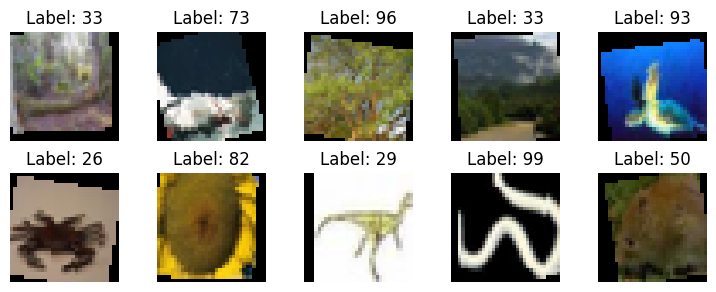

Start training on CIFAR100
Length of train dataset: 50000
Length of test dataset: 10000
Number of trainable parameters: 85,269,220
Device: cuda


100%|██████████| 1563/1563 [01:55<00:00, 13.52it/s]


Epoch 1: Train Loss: 3.4610, Accuracy: 0.1774, Test Loss: 3.1447, Test Accuracy: 0.2306


100%|██████████| 1563/1563 [01:54<00:00, 13.60it/s]


Epoch 2: Train Loss: 3.0435, Accuracy: 0.2499, Test Loss: 2.9439, Test Accuracy: 0.2670


100%|██████████| 1563/1563 [01:54<00:00, 13.66it/s]


Epoch 3: Train Loss: 2.8747, Accuracy: 0.2831, Test Loss: 2.7928, Test Accuracy: 0.2989


100%|██████████| 1563/1563 [01:55<00:00, 13.49it/s]


Epoch 4: Train Loss: 2.7595, Accuracy: 0.3055, Test Loss: 2.7574, Test Accuracy: 0.3076


100%|██████████| 1563/1563 [01:54<00:00, 13.61it/s]


Epoch 5: Train Loss: 2.6586, Accuracy: 0.3253, Test Loss: 2.6243, Test Accuracy: 0.3358


100%|██████████| 1563/1563 [01:54<00:00, 13.62it/s]


Epoch 6: Train Loss: 2.5811, Accuracy: 0.3411, Test Loss: 2.5897, Test Accuracy: 0.3448


100%|██████████| 1563/1563 [01:54<00:00, 13.65it/s]


Epoch 7: Train Loss: 2.5080, Accuracy: 0.3540, Test Loss: 2.5470, Test Accuracy: 0.3576


100%|██████████| 1563/1563 [01:55<00:00, 13.59it/s]


Epoch 8: Train Loss: 2.3442, Accuracy: 0.3925, Test Loss: 2.4636, Test Accuracy: 0.3735


100%|██████████| 1563/1563 [01:54<00:00, 13.65it/s]


Epoch 9: Train Loss: 2.3067, Accuracy: 0.3996, Test Loss: 2.4272, Test Accuracy: 0.3835


100%|██████████| 1563/1563 [01:54<00:00, 13.67it/s]


Epoch 10: Train Loss: 2.2840, Accuracy: 0.4043, Test Loss: 2.4151, Test Accuracy: 0.3846


100%|██████████| 1563/1563 [01:54<00:00, 13.66it/s]


Epoch 11: Train Loss: 2.2632, Accuracy: 0.4115, Test Loss: 2.4121, Test Accuracy: 0.3837


100%|██████████| 1563/1563 [01:55<00:00, 13.48it/s]


Epoch 12: Train Loss: 2.2484, Accuracy: 0.4133, Test Loss: 2.4068, Test Accuracy: 0.3775


100%|██████████| 1563/1563 [01:55<00:00, 13.49it/s]


Epoch 13: Train Loss: 2.2357, Accuracy: 0.4158, Test Loss: 2.3930, Test Accuracy: 0.3875


100%|██████████| 1563/1563 [01:54<00:00, 13.63it/s]


Epoch 14: Train Loss: 2.2246, Accuracy: 0.4180, Test Loss: 2.3852, Test Accuracy: 0.3939


100%|██████████| 1563/1563 [01:54<00:00, 13.65it/s]


Epoch 15: Train Loss: 2.2076, Accuracy: 0.4215, Test Loss: 2.3884, Test Accuracy: 0.3897


100%|██████████| 1563/1563 [01:54<00:00, 13.66it/s]


Early stopping due to insufficient loss improvement


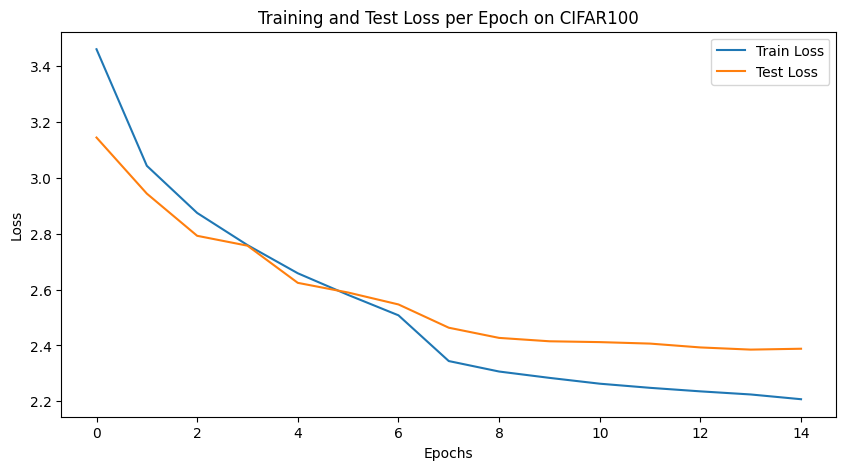

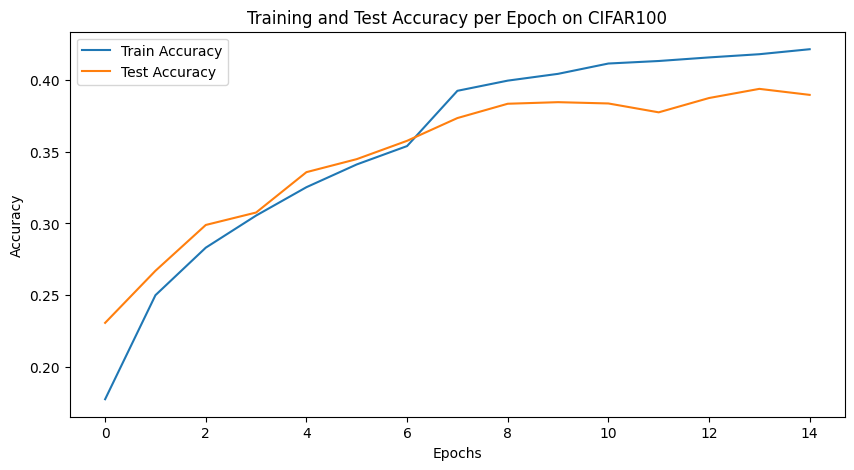

Training on CIFAR-100 completed successfully.


In [ ]:
# Define the transformations for CIFAR-100
cifar100_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.RandomCrop(32, padding=4),  # Randomly crop the images with padding
    transforms.RandomRotation(15),  # Randomly rotate the images by up to 15 degrees
    transforms.ToTensor(),  # Convert the images to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Call the setup_and_train function with CIFAR-100 specific parameters
cifar100_head = setup_and_train(
    dataset_name='CIFAR100',  # Specify dataset name as CIFAR-100
    num_classes=100,  # CIFAR-100 has 100 classes
    transform=cifar100_transform,  # Use the defined transformations
    batch_size=batch_size,  # Batch size (you can adjust this based on your system capabilities)
    epochs=20,  # Number of training epochs
    save_head=True,  # Choose to save the model head for later use
    min_loss_improvement=0.005  # Set minimum improvement in loss for early stopping
)

print("Training on CIFAR-100 completed successfully.")

###### Finetuning On The MNIST Dataset

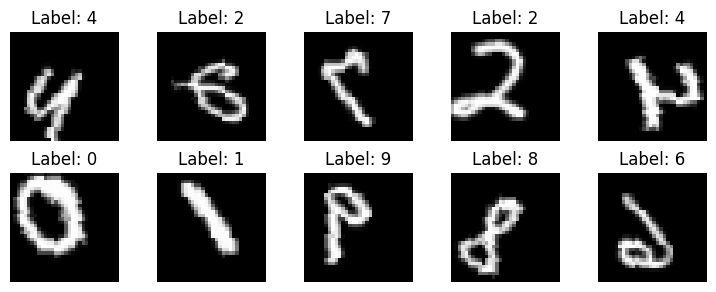

Start training on MNIST
Length of train dataset: 60000
Length of test dataset: 10000
Number of trainable parameters: 85,200,010
Device: cuda


100%|██████████| 1875/1875 [02:09<00:00, 14.45it/s]


Epoch 1: Train Loss: 0.5323, Accuracy: 0.8178, Test Loss: 0.2907, Test Accuracy: 0.9017


100%|██████████| 1875/1875 [02:09<00:00, 14.48it/s]


Epoch 2: Train Loss: 0.2853, Accuracy: 0.9056, Test Loss: 0.1944, Test Accuracy: 0.9370


100%|██████████| 1875/1875 [02:10<00:00, 14.35it/s]


Epoch 3: Train Loss: 0.2210, Accuracy: 0.9268, Test Loss: 0.1621, Test Accuracy: 0.9464


100%|██████████| 1875/1875 [02:09<00:00, 14.46it/s]


Epoch 4: Train Loss: 0.1789, Accuracy: 0.9425, Test Loss: 0.1307, Test Accuracy: 0.9573


100%|██████████| 1875/1875 [02:10<00:00, 14.39it/s]


Epoch 5: Train Loss: 0.1625, Accuracy: 0.9482, Test Loss: 0.1177, Test Accuracy: 0.9634


100%|██████████| 1875/1875 [02:09<00:00, 14.45it/s]


Epoch 6: Train Loss: 0.1438, Accuracy: 0.9530, Test Loss: 0.1035, Test Accuracy: 0.9658


100%|██████████| 1875/1875 [02:10<00:00, 14.33it/s]


Epoch 7: Train Loss: 0.1331, Accuracy: 0.9563, Test Loss: 0.1061, Test Accuracy: 0.9651


100%|██████████| 1875/1875 [02:09<00:00, 14.48it/s]


Epoch 8: Train Loss: 0.0972, Accuracy: 0.9685, Test Loss: 0.0740, Test Accuracy: 0.9746


100%|██████████| 1875/1875 [02:09<00:00, 14.43it/s]


Epoch 9: Train Loss: 0.0874, Accuracy: 0.9715, Test Loss: 0.0723, Test Accuracy: 0.9771


100%|██████████| 1875/1875 [02:09<00:00, 14.47it/s]



Early stopping due to insufficient loss improvement


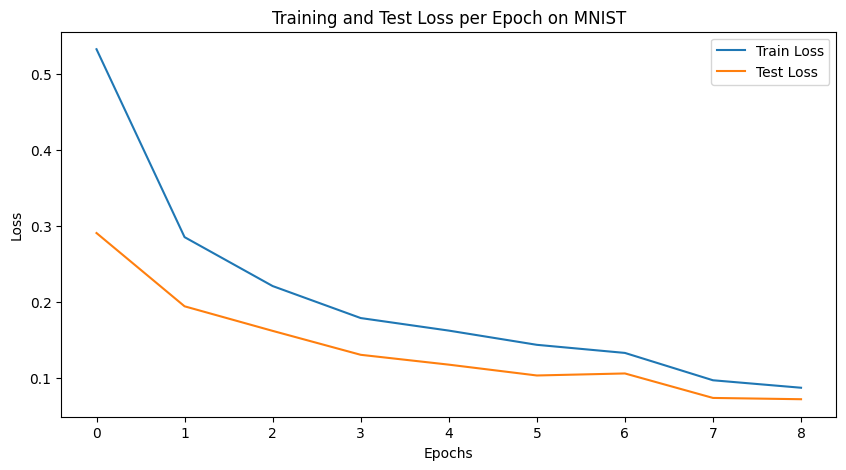

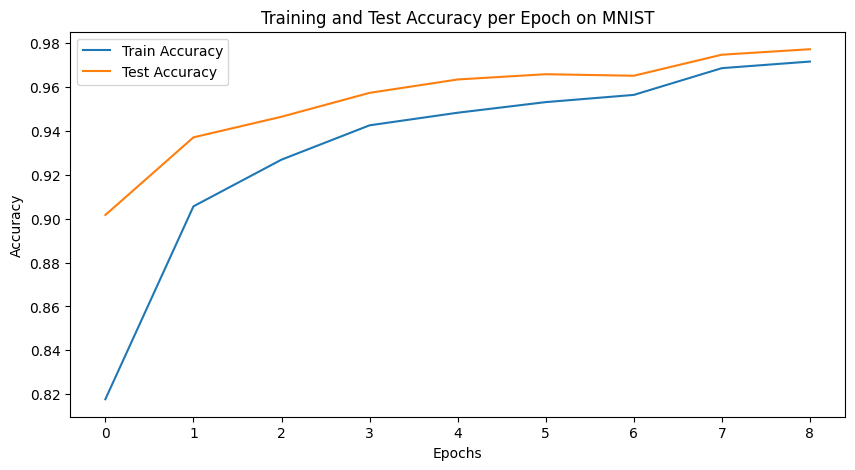

Training on MNIST completed successfully.


In [ ]:
# Define the transformations for MNIST
mnist_transform = transforms.Compose([
    transforms.Resize(32),  # Resize the images from 28x28 to 32x32 to match CIFAR's size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale to mimic RGB channels
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.RandomCrop(32, padding=4),  # Randomly crop the images with padding
    transforms.RandomRotation(15),  # Randomly rotate the images by up to 15 degrees
    transforms.ToTensor(),  # Convert the images to Tensor format
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images using mean and std suitable for grayscale
])

# Call the setup_and_train function with MNIST specific parameters
mnist_head = setup_and_train(
    dataset_name='MNIST',  # Specify dataset name as MNIST
    num_classes=10,  # MNIST has 10 classes, one for each digit
    transform=mnist_transform,  # Use the defined transformations
    batch_size=batch_size,  # Batch size (you can adjust this based on your system capabilities)
    epochs=10,  # Number of training epochs
    save_head=True,  # Choose to save the model head for later use
    min_loss_improvement=0.005  # Set minimum improvement in loss for early stopping
)

print("Training on MNIST completed successfully.")

###### Finetuning On The Fashion-MNIST Dataset

100%|██████████| 26421880/26421880 [00:02<00:00, 8946077.59it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 146049.98it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2248762.76it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8798808.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



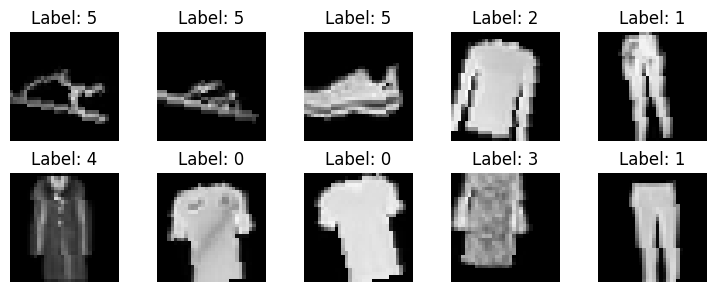

Start training on FashionMNIST
Length of train dataset: 60000
Length of test dataset: 10000
Number of trainable parameters: 85,200,010
Device: cuda


100%|██████████| 1875/1875 [02:10<00:00, 14.41it/s]


Epoch 1: Train Loss: 0.5878, Accuracy: 0.7798, Test Loss: 0.5045, Test Accuracy: 0.8036


100%|██████████| 1875/1875 [02:09<00:00, 14.44it/s]


Epoch 2: Train Loss: 0.4675, Accuracy: 0.8221, Test Loss: 0.4277, Test Accuracy: 0.8378


100%|██████████| 1875/1875 [02:09<00:00, 14.44it/s]


Epoch 3: Train Loss: 0.4313, Accuracy: 0.8361, Test Loss: 0.4228, Test Accuracy: 0.8420


100%|██████████| 1875/1875 [02:09<00:00, 14.44it/s]


Epoch 4: Train Loss: 0.4104, Accuracy: 0.8451, Test Loss: 0.3928, Test Accuracy: 0.8530


100%|██████████| 1875/1875 [02:09<00:00, 14.46it/s]


Epoch 5: Train Loss: 0.3911, Accuracy: 0.8521, Test Loss: 0.3873, Test Accuracy: 0.8534


100%|██████████| 1875/1875 [02:09<00:00, 14.45it/s]


Epoch 6: Train Loss: 0.3799, Accuracy: 0.8571, Test Loss: 0.3818, Test Accuracy: 0.8584


100%|██████████| 1875/1875 [02:11<00:00, 14.28it/s]


Epoch 7: Train Loss: 0.3698, Accuracy: 0.8600, Test Loss: 0.3858, Test Accuracy: 0.8572


100%|██████████| 1875/1875 [02:10<00:00, 14.40it/s]


Epoch 8: Train Loss: 0.3344, Accuracy: 0.8733, Test Loss: 0.3341, Test Accuracy: 0.8776


100%|██████████| 1875/1875 [02:10<00:00, 14.41it/s]


Epoch 9: Train Loss: 0.3221, Accuracy: 0.8793, Test Loss: 0.3305, Test Accuracy: 0.8779


100%|██████████| 1875/1875 [02:10<00:00, 14.36it/s]


Epoch 10: Train Loss: 0.3159, Accuracy: 0.8806, Test Loss: 0.3246, Test Accuracy: 0.8807


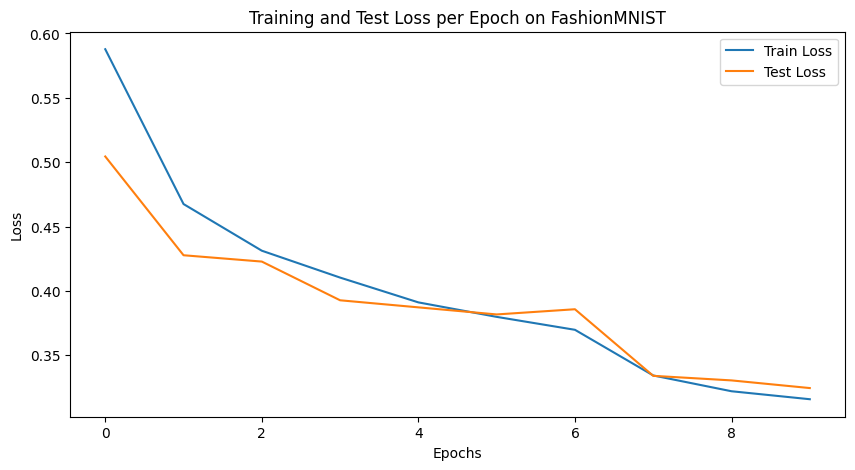

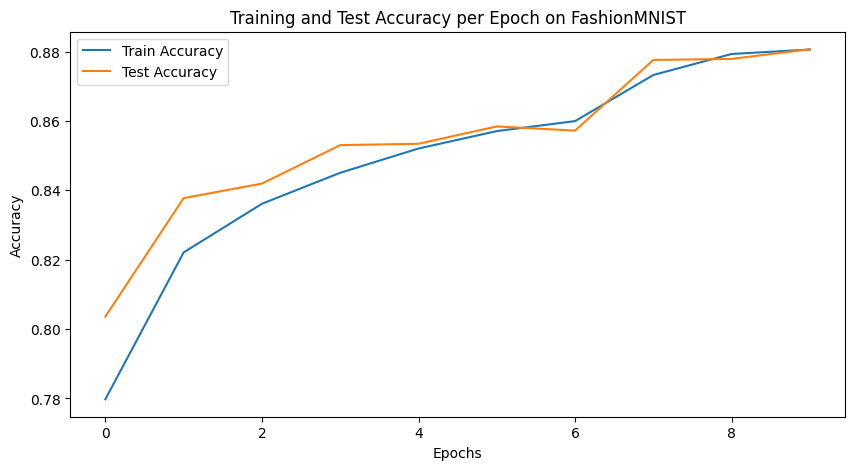

Training on Fashion-MNIST completed successfully.


In [ ]:
# Define transformations for Fashion-MNIST
fashion_transform = transforms.Compose([
    transforms.Resize(32),  # Resize the images from 28x28 to 32x32 to match CIFAR's size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale to mimic RGB channels
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.RandomCrop(32, padding=4),  # Randomly crop the images with padding
    transforms.RandomRotation(15),  # Randomly rotate the images by up to 15 degrees
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Define a new classification head if needed
# Assuming the feature dimension before the classifier is 512 (adjust according to your model architecture)
#new_head = nn.Linear(512, 10)  # Fashion-MNIST has 10 classes

# Call the setup_and_train function for Fashion-MNIST
fashion_mnist_head = setup_and_train(
    dataset_name='FashionMNIST',    # Specify the dataset
    num_classes=10,                 # Number of classes in Fashion-MNIST
    transform=fashion_transform,    # Use the defined transformations
    batch_size=batch_size,                  # Batch size for training
    epochs=10,                      # Number of epochs to train
    save_head=True,                 # Option to save the final trained head
    #classification_head=new_head    # Optional: Pass a new classification head if needed
)

print("Training on Fashion-MNIST completed successfully.")

###### Finetuning On The STL-10 Dataset

100%|██████████| 2640397119/2640397119 [05:23<00:00, 8153618.62it/s] 


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


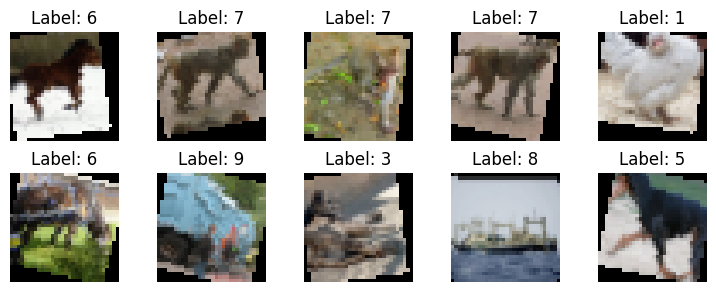

Start training on STL10
Length of train dataset: 5000
Length of test dataset: 8000
Number of trainable parameters: 85,200,010
Device: cuda


100%|██████████| 157/157 [00:19<00:00,  8.15it/s]


Epoch 1: Train Loss: 1.7604, Accuracy: 0.3352, Test Loss: 1.5784, Test Accuracy: 0.4151


100%|██████████| 157/157 [00:19<00:00,  8.18it/s]


Epoch 2: Train Loss: 1.5190, Accuracy: 0.4325, Test Loss: 1.5047, Test Accuracy: 0.4358


100%|██████████| 157/157 [00:19<00:00,  8.15it/s]


Epoch 3: Train Loss: 1.4307, Accuracy: 0.4693, Test Loss: 1.4115, Test Accuracy: 0.4798


100%|██████████| 157/157 [00:19<00:00,  8.18it/s]


Epoch 4: Train Loss: 1.3849, Accuracy: 0.4934, Test Loss: 1.3981, Test Accuracy: 0.4919


100%|██████████| 157/157 [00:19<00:00,  8.21it/s]


Epoch 5: Train Loss: 1.3271, Accuracy: 0.5062, Test Loss: 1.3875, Test Accuracy: 0.5015


100%|██████████| 157/157 [00:19<00:00,  8.21it/s]


Epoch 6: Train Loss: 1.2923, Accuracy: 0.5195, Test Loss: 1.3784, Test Accuracy: 0.5030


100%|██████████| 157/157 [00:19<00:00,  8.15it/s]


Epoch 7: Train Loss: 1.2490, Accuracy: 0.5376, Test Loss: 1.3181, Test Accuracy: 0.5195


100%|██████████| 157/157 [00:19<00:00,  8.12it/s]


Epoch 8: Train Loss: 1.1890, Accuracy: 0.5655, Test Loss: 1.2792, Test Accuracy: 0.5350


100%|██████████| 157/157 [00:19<00:00,  8.15it/s]


Epoch 9: Train Loss: 1.1718, Accuracy: 0.5693, Test Loss: 1.2837, Test Accuracy: 0.5375


100%|██████████| 157/157 [00:19<00:00,  8.20it/s]


Epoch 10: Train Loss: 1.1550, Accuracy: 0.5766, Test Loss: 1.2889, Test Accuracy: 0.5348


100%|██████████| 157/157 [00:19<00:00,  8.18it/s]


Early stopping due to insufficient loss improvement


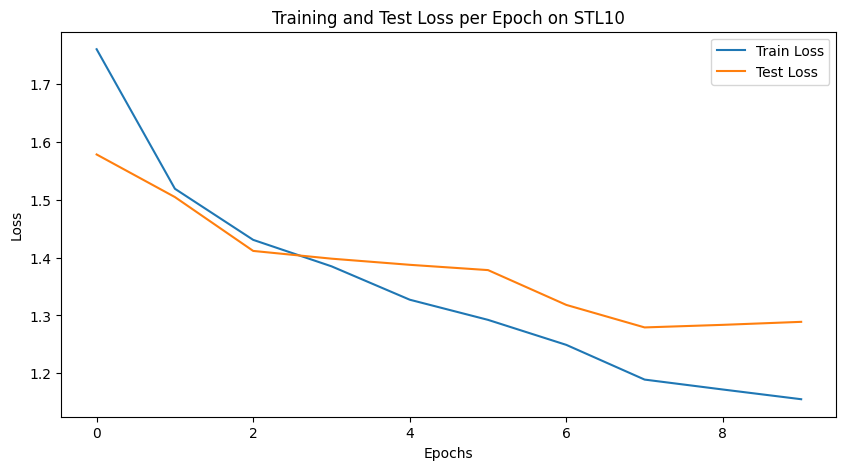

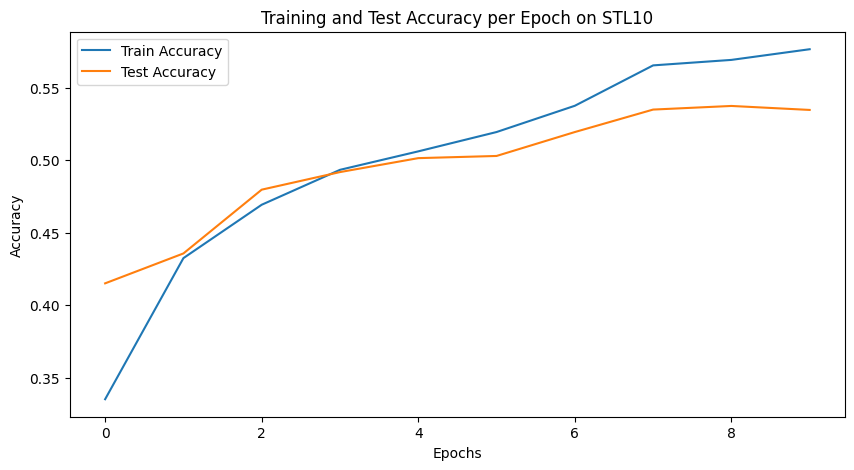

Training on STL-10 completed successfully.


In [ ]:
# Define transformations for STL-10
# STL-10 images are larger, so we may not need to resize them if the network can handle 96x96 input
stl_transform = transforms.Compose([
    transforms.Resize(32),  # Resize the images to 32x32 to match CIFAR's size
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.RandomCrop(32, padding=4),  # Randomly crop the images with padding
    transforms.RandomRotation(15),  # Randomly rotate the images by up to 15 degrees
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images (assuming RGB)
])

# Optional: Define a new classification head if the model architecture requires it
# Example for a model feature dimension before the classifier, e.g., 512
#new_head = nn.Linear(512, 10)  # STL-10 has 10 classes

# Call the setup_and_train function for STL-10
stl10_head = setup_and_train(
    dataset_name='STL10',            # Specify the dataset
    num_classes=10,                  # Number of classes in STL-10
    transform=stl_transform,         # Use the defined transformations
    batch_size=batch_size,                   # Batch size for training
    epochs=20,                       # Number of epochs to train
    save_head=True,                  # Option to save the final trained head
    classification_head=None     # Optional: Pass a new classification head if needed
)

print("Training on STL-10 completed successfully.")

###### Finetuning On The SVHN Dataset

100%|██████████| 182040794/182040794 [00:25<00:00, 7036691.77it/s] 


100%|██████████| 64275384/64275384 [00:15<00:00, 4169273.59it/s]


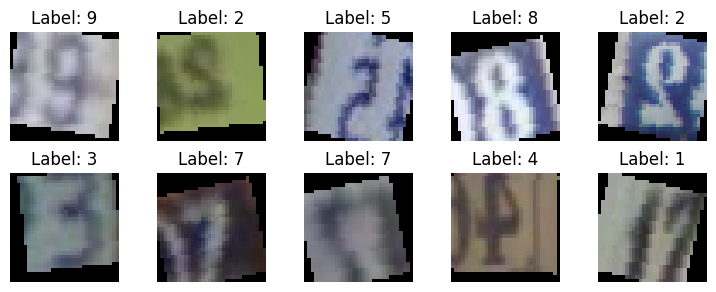

Start training on SVHN
Length of train dataset: 73257
Length of test dataset: 26032
Number of trainable parameters: 85,200,010
Device: cuda


100%|██████████| 2290/2290 [02:45<00:00, 13.84it/s]


Epoch 1: Train Loss: 1.1174, Accuracy: 0.6264, Test Loss: 0.7713, Test Accuracy: 0.7493


100%|██████████| 2290/2290 [02:44<00:00, 13.93it/s]


Epoch 2: Train Loss: 0.7558, Accuracy: 0.7531, Test Loss: 0.6333, Test Accuracy: 0.8003


100%|██████████| 2290/2290 [02:45<00:00, 13.87it/s]


Epoch 3: Train Loss: 0.6403, Accuracy: 0.7928, Test Loss: 0.5451, Test Accuracy: 0.8272


100%|██████████| 2290/2290 [02:44<00:00, 13.92it/s]


Epoch 4: Train Loss: 0.5739, Accuracy: 0.8140, Test Loss: 0.5080, Test Accuracy: 0.8422


100%|██████████| 2290/2290 [02:44<00:00, 13.94it/s]


Epoch 5: Train Loss: 0.5264, Accuracy: 0.8315, Test Loss: 0.4551, Test Accuracy: 0.8585


100%|██████████| 2290/2290 [02:44<00:00, 13.88it/s]


Epoch 6: Train Loss: 0.4870, Accuracy: 0.8436, Test Loss: 0.4348, Test Accuracy: 0.8665


100%|██████████| 2290/2290 [02:44<00:00, 13.96it/s]


Epoch 7: Train Loss: 0.4648, Accuracy: 0.8533, Test Loss: 0.4120, Test Accuracy: 0.8729


100%|██████████| 2290/2290 [02:44<00:00, 13.91it/s]


Epoch 8: Train Loss: 0.3992, Accuracy: 0.8737, Test Loss: 0.3645, Test Accuracy: 0.8911


100%|██████████| 2290/2290 [02:44<00:00, 13.90it/s]


Epoch 9: Train Loss: 0.3784, Accuracy: 0.8812, Test Loss: 0.3502, Test Accuracy: 0.8941


100%|██████████| 2290/2290 [02:44<00:00, 13.94it/s]


Epoch 10: Train Loss: 0.3724, Accuracy: 0.8834, Test Loss: 0.3391, Test Accuracy: 0.8988


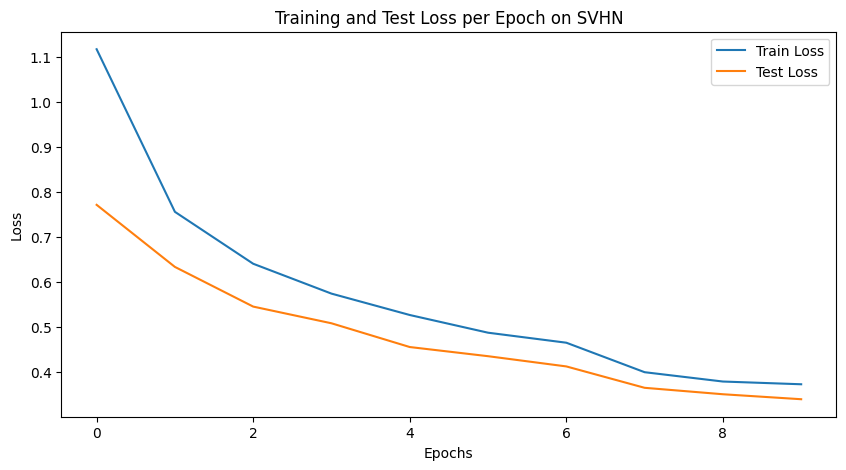

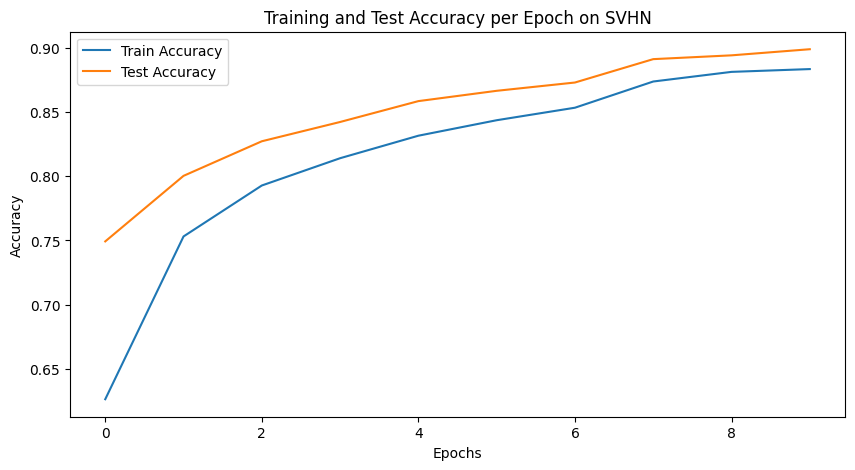

Training on SVHN completed successfully.


In [ ]:
# Define transformations for SVHN
svhn_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.RandomCrop(32, padding=4),  # Randomly crop the images with padding
    transforms.RandomRotation(15),  # Randomly rotate the images by up to 15 degrees
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images assuming RGB
])

# Optional: Define a new classification head if your model architecture requires it
# Example assuming the feature dimension before the classifier is 512
#new_head = nn.Linear(512, 10)  # SVHN has 10 classes

# Call the setup_and_train function for SVHN
svhn_head = setup_and_train(
    dataset_name='SVHN',             # Specify the dataset
    num_classes=10,                  # Number of classes in SVHN
    transform=svhn_transform,        # Use the defined transformations
    batch_size=batch_size,                   # Batch size for training
    epochs=10,                       # Number of epochs to train
    save_head=True,                  # Option to save the final trained head
    classification_head=None     # Optional: Pass a new classification head if needed
)

print("Training on SVHN completed successfully.")

###### Finetuning On The Oxford Pets Dataset

100%|██████████| 791918971/791918971 [00:54<00:00, 14582124.04it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7362754.95it/s] 


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


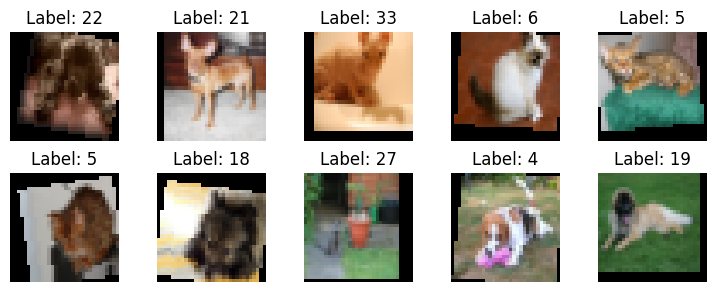

Start training on OxfordIIITPet
Length of train dataset: 6615
Length of test dataset: 734
Number of trainable parameters: 85,220,773
Device: cuda


100%|██████████| 207/207 [00:20<00:00,  9.92it/s]


Epoch 1: Train Loss: 3.4476, Accuracy: 0.0740, Test Loss: 3.8483, Test Accuracy: 0.0122


100%|██████████| 207/207 [00:20<00:00,  9.95it/s]


Epoch 2: Train Loss: 3.1375, Accuracy: 0.1461, Test Loss: 3.8391, Test Accuracy: 0.0245


100%|██████████| 207/207 [00:20<00:00, 10.00it/s]


Epoch 3: Train Loss: 2.9595, Accuracy: 0.1862, Test Loss: 3.6950, Test Accuracy: 0.0231


100%|██████████| 207/207 [00:20<00:00,  9.98it/s]


Epoch 4: Train Loss: 2.8662, Accuracy: 0.2010, Test Loss: 3.5731, Test Accuracy: 0.0584


100%|██████████| 207/207 [00:20<00:00,  9.97it/s]


Epoch 5: Train Loss: 2.7812, Accuracy: 0.2266, Test Loss: 3.4793, Test Accuracy: 0.0639


100%|██████████| 207/207 [00:20<00:00, 10.00it/s]


Epoch 6: Train Loss: 2.7131, Accuracy: 0.2429, Test Loss: 3.4886, Test Accuracy: 0.0720


100%|██████████| 207/207 [00:20<00:00,  9.97it/s]


Epoch 7: Train Loss: 2.6434, Accuracy: 0.2613, Test Loss: 3.6435, Test Accuracy: 0.0666


100%|██████████| 207/207 [00:20<00:00,  9.98it/s]


Epoch 8: Train Loss: 2.5399, Accuracy: 0.2839, Test Loss: 3.5256, Test Accuracy: 0.0803


100%|██████████| 207/207 [00:20<00:00,  9.92it/s]


Epoch 9: Train Loss: 2.4915, Accuracy: 0.2997, Test Loss: 3.4423, Test Accuracy: 0.0883


100%|██████████| 207/207 [00:20<00:00, 10.01it/s]



Early stopping due to insufficient loss improvement


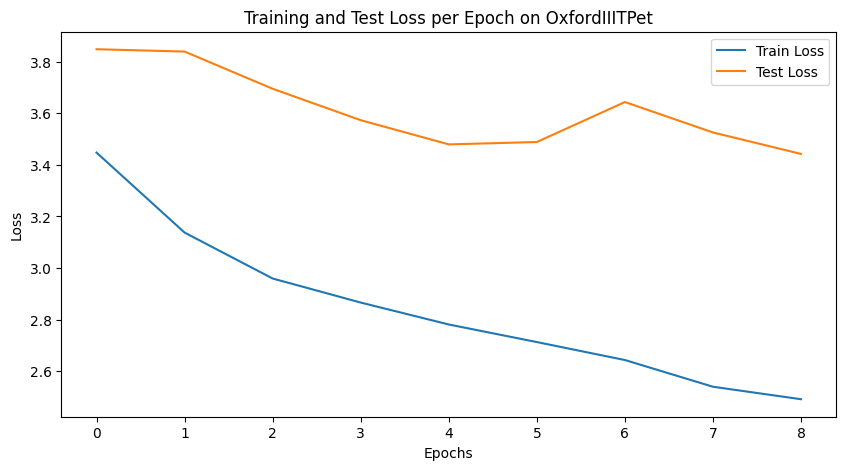

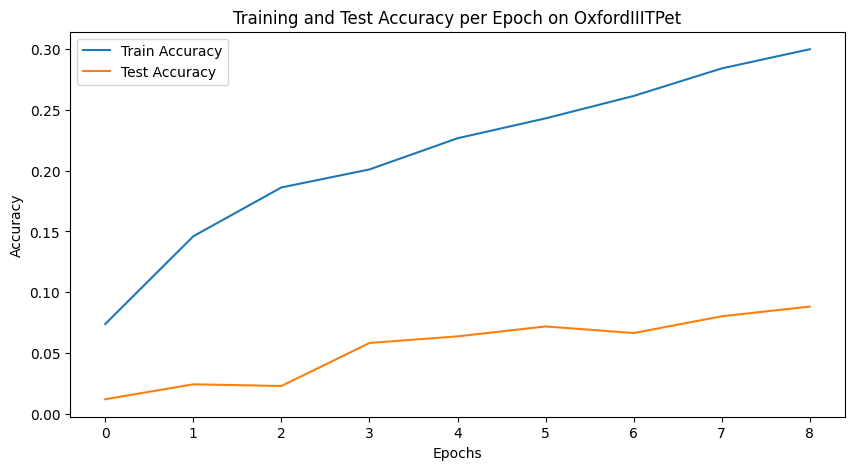

In [ ]:
# Example usage
pets_transform = transforms.Compose([
    transforms.Resize((32,32)),  # Resize to conform with common image sizes for pre-trained models
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.RandomCrop(32, padding=4),  # Randomly crop the images with padding
    transforms.RandomRotation(15),  # Randomly rotate the images by up to 15 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

pets_head = setup_and_train('OxfordIIITPet', 37, pets_transform, batch_size=batch_size, epochs=15, save_head=True)

###### Finetuning On The Oxford Flowers Dataset

100%|██████████| 344862509/344862509 [00:23<00:00, 14479317.61it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 687411.23it/s]


100%|██████████| 14989/14989 [00:00<00:00, 15149017.51it/s]


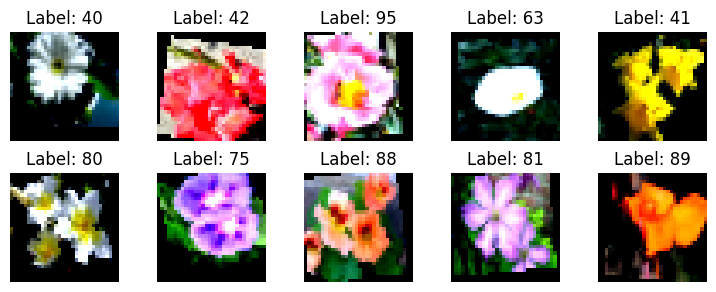

Start training on OxfordFlowers102
Length of train dataset: 6149
Length of test dataset: 1020
Number of trainable parameters: 85,270,758
Device: cuda


100%|██████████| 193/193 [00:19<00:00,  9.78it/s]


Epoch 1: Train Loss: 3.7106, Accuracy: 0.1486, Test Loss: 3.5683, Test Accuracy: 0.1514


100%|██████████| 193/193 [00:19<00:00,  9.85it/s]


Epoch 2: Train Loss: 2.8477, Accuracy: 0.3022, Test Loss: 3.1275, Test Accuracy: 0.2473


100%|██████████| 193/193 [00:19<00:00,  9.81it/s]


Epoch 3: Train Loss: 2.4771, Accuracy: 0.3769, Test Loss: 2.7536, Test Accuracy: 0.3156


100%|██████████| 193/193 [00:19<00:00,  9.81it/s]


Epoch 4: Train Loss: 2.2019, Accuracy: 0.4415, Test Loss: 2.6270, Test Accuracy: 0.3093


100%|██████████| 193/193 [00:19<00:00,  9.85it/s]


Epoch 5: Train Loss: 2.0162, Accuracy: 0.4810, Test Loss: 2.4166, Test Accuracy: 0.3881


100%|██████████| 193/193 [00:19<00:00,  9.74it/s]


Epoch 6: Train Loss: 1.8577, Accuracy: 0.5093, Test Loss: 2.3546, Test Accuracy: 0.3832


100%|██████████| 193/193 [00:19<00:00,  9.82it/s]


Epoch 7: Train Loss: 1.7461, Accuracy: 0.5423, Test Loss: 2.2197, Test Accuracy: 0.4195


100%|██████████| 193/193 [00:19<00:00,  9.81it/s]


Epoch 8: Train Loss: 1.5761, Accuracy: 0.5803, Test Loss: 2.1544, Test Accuracy: 0.4435


100%|██████████| 193/193 [00:19<00:00,  9.84it/s]


Epoch 9: Train Loss: 1.5319, Accuracy: 0.5995, Test Loss: 2.1780, Test Accuracy: 0.4286


100%|██████████| 193/193 [00:19<00:00,  9.85it/s]


Epoch 10: Train Loss: 1.5135, Accuracy: 0.5929, Test Loss: 2.1182, Test Accuracy: 0.4519


100%|██████████| 193/193 [00:19<00:00,  9.80it/s]


Epoch 11: Train Loss: 1.4961, Accuracy: 0.6099, Test Loss: 2.1010, Test Accuracy: 0.4491


100%|██████████| 193/193 [00:19<00:00,  9.77it/s]


Epoch 12: Train Loss: 1.4749, Accuracy: 0.6075, Test Loss: 2.0977, Test Accuracy: 0.4492


100%|██████████| 193/193 [00:19<00:00,  9.84it/s]


Epoch 13: Train Loss: 1.4645, Accuracy: 0.6144, Test Loss: 2.1153, Test Accuracy: 0.4549


100%|██████████| 193/193 [00:19<00:00,  9.84it/s]


Epoch 14: Train Loss: 1.4513, Accuracy: 0.6140, Test Loss: 2.1099, Test Accuracy: 0.4495


100%|██████████| 193/193 [00:19<00:00,  9.88it/s]


Epoch 15: Train Loss: 1.4186, Accuracy: 0.6220, Test Loss: 2.0529, Test Accuracy: 0.4658


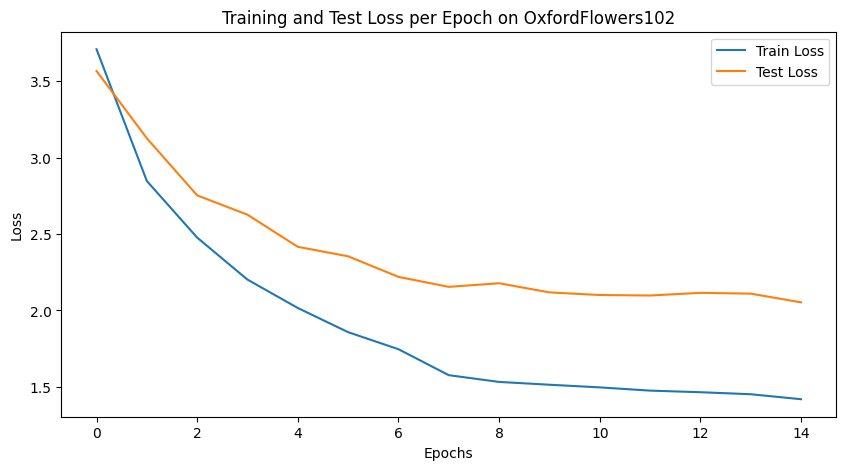

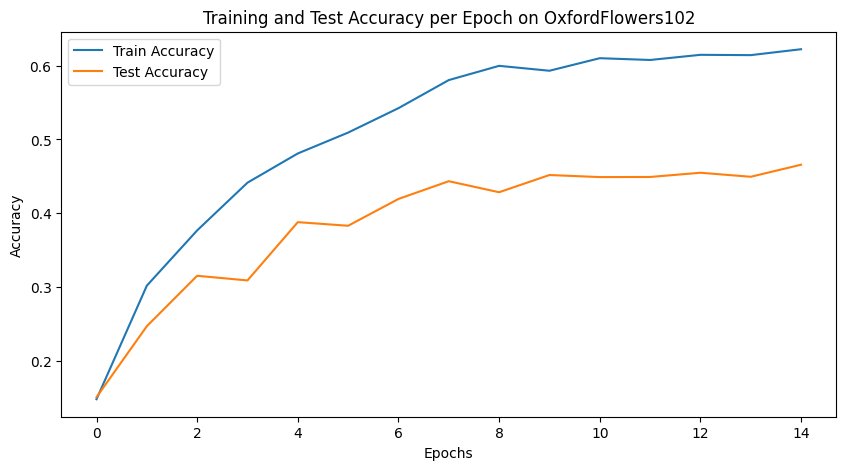

Training on Oxford Flowers102 completed successfully.


In [ ]:
# Define transformations
flowers_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to common image size
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.RandomCrop(32, padding=4),  # Randomly crop the images with padding
    transforms.RandomRotation(15),  # Randomly rotate the images by up to 15 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Call the setup_and_train function for Oxford Flowers102
flowers_head = setup_and_train('OxfordFlowers102', 102, flowers_transform, batch_size=batch_size, epochs=15, save_head=True)
print("Training on Oxford Flowers102 completed successfully.")

###### Testing The Trained Model

In [ ]:
def evaluate_model(dataset_name, transform, saved_head, num_classes, batch_size=64):
    """
    Evaluate the model on the test set of a specified dataset using a saved classification head.

    Args:
    dataset_name (str): The name of the dataset.
    transform (transforms.Compose): Transformations applied to the dataset.
    saved_head (dict): State dictionary of the saved classification head.
    num_classes (int): Number of classes in the dataset.
    batch_size (int): Batch size used for loading test data.
    """
    import torchvision.datasets as datasets
    from torch.utils.data import DataLoader
    from torch import nn, device

    # Define the device for model evaluation based on GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the test dataset
    if dataset_name == 'SVHN':
        testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
    elif dataset_name == 'STL10':
        testset = datasets.STL10(root='./data', split='test', download=True, transform=transform)
    elif dataset_name == 'OxfordIIITPet':
        testset = datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=transform)
    elif dataset_name == 'OxfordFlowers102':
        testset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
    else:
        TestSet = getattr(datasets, dataset_name)
        testset = TestSet(root='./data', train=False, download=True, transform=transform)

    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Attach the saved classification head
    num_ftrs = model.mlp_head.in_features
    model.mlp_head = nn.Linear(num_ftrs, num_classes)
    model.mlp_head.load_state_dict(saved_head)
    model.to(device)

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the {dataset_name} test images: {accuracy:.2f}%')
    return accuracy


In [ ]:
# Example calls for evaluating each dataset
evaluate_model('CIFAR10', cifar_transform, cifar10_head, 10)
evaluate_model('CIFAR100', cifar100_transform, cifar100_head, 100)
evaluate_model('MNIST', mnist_transform, mnist_head, 10)
evaluate_model('FashionMNIST', fashion_transform, fashion_mnist_head, 10)
evaluate_model('STL10', stl_transform, stl10_head, 10)
evaluate_model('SVHN', svhn_transform, svhn_head, 10)  # SVHN has 10 classes
evaluate_model('OxfordIIITPet', pets_transform, pets_head, 37)  # OxfordIIITPet has 37 classes
evaluate_model('OxfordFlowers102', flowers_transform, flowers_head, 102)  # SVHN has 10 classes

Files already downloaded and verified
Accuracy of the model on the CIFAR10 test images: 17.61%
Files already downloaded and verified
Accuracy of the model on the CIFAR100 test images: 4.44%
Accuracy of the model on the MNIST test images: 50.49%
Accuracy of the model on the FashionMNIST test images: 53.45%
Files already downloaded and verified
Accuracy of the model on the STL10 test images: 33.33%
Using downloaded and verified file: ./data/test_32x32.mat
Accuracy of the model on the SVHN test images: 47.08%
Accuracy of the model on the OxfordIIITPet test images: 14.12%
Accuracy of the model on the OxfordFlowers102 test images: 44.02%


44.01960784313726

References
[Article](https://blog.mdturp.ch/posts/2024-04-05-visual_guide_to_vision_transformer.html) | [Code](https://colab.research.google.com/drive/1r_cmWE9RbjkwyqKbhnX5GAtenoFvBurM?usp=sharing#scrollTo=jXriRS8CTaR7)




In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def plot_attention_maps(model, dataset, num_images=5, device='cuda'):
    model.eval()  # Set model to evaluation mode to disable dropout layers

    # DataLoader to load images
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)

    # Get a batch of images and their labels
    images, labels = next(iter(loader))
    images = images.to(device)

    # Forward pass to get attention weights
    with torch.no_grad():
        # Forward pass through the model to get the raw scores and attention
        # For ViT, assuming the model returns attention weights in addition to the class scores
        logits, attention_weights = model(images, return_attention_weights=True)

    # Assuming attention_weights is a list of tuples for each layer, and we need the last layer
    last_layer_attention = attention_weights[-1]  # Get attention of the last layer
    b, n_heads, n_patches, _ = last_layer_attention.shape  # Shape: (batch, heads, patches, patches)

    # Process each image in the batch
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 2 * num_images))
    for idx, (img, attn) in enumerate(zip(images, last_layer_attention)):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Assuming normalization mean=0.5, std=0.5

        # Summing across heads and taking the mean to visualize the combined attention
        attn = attn.mean(dim=0)  # Shape after: (patches, patches)
        attention_map = attn[0, 1:].reshape(1 + int((32 // 8)**2)).view(32 // 8, 32 // 8).cpu().numpy()

        axs[idx, 0].imshow(img)
        axs[idx, 0].axis('off')
        axs[idx, 0].set_title(f'Label: {labels[idx]}')

        axs[idx, 1].imshow(attention_map, cmap='viridis')
        axs[idx, 1].axis('off')
        axs[idx, 1].set_title('Attention Map')

    plt.tight_layout()
    plt.show()

# Usage example (assuming the model and dataset are already defined and loaded)
# plot_attention_maps(model, test_dataset, num_images=5)
